In [1]:
import os
import pandas as pd
from __future__ import division

import misc.SDH_Conference_TestCases.CaseFuture as cf

from runOpt import get_json
from pkg_resources import resource_filename

In [2]:
repr_days = get_json(resource_filename('TimeSliceSelection', '../Scripts/NoSeasons/ordered_solutions1_20bins_new.txt'))
num_days = 12

### Full optimization

In [3]:
opt_full = cf.setup_opt()

In [4]:
opt_full.compile()
opt_full.set_objective('energy')

In [5]:
opt_full.solve(tee=True, solver='gurobi')

Academic license - for non-commercial use only
Read LP format model from file /home/thesysi/modesto/misc/RepresentativePeriodsMILP/tmpcR4Oeg.pyomo.lp
Reading time = 1.69 seconds
x490570: 727096 rows, 481810 columns, 1559302 nonzeros
Optimize a model with 727096 rows, 481810 columns and 1559302 nonzeros
Coefficient statistics:
  Matrix range     [4e-06, 2e+05]
  Objective range  [1e-03, 1e+00]
  Bounds range     [1e+02, 1e+04]
  RHS range        [2e-17, 6e+11]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 437172 rows and 305766 columns
Presolve time: 1.64s
Presolved: 289924 rows, 176044 columns, 837657 nonzeros

Ordering time: 0.18s

Barrier statistics:
 Free vars  : 421
 AA' NZ     : 2.114e+06
 Factor NZ  : 4.068e+06 (roughly 200 MBytes of memory)
 Factor Ops : 7.404e+07 (less than 1 second per iteration)
 Thread

0

## Representative optimization

In [6]:
opt_repr = cf.setup_opt(repr=repr_days[num_days])

In [7]:
opt_repr.compile()
opt_repr.set_objective('energy')

In [8]:
opt_repr.solve(tee=True, solver='gurobi')

Academic license - for non-commercial use only
Read LP format model from file /home/thesysi/modesto/misc/RepresentativePeriodsMILP/tmpa22TeD.pyomo.lp
Reading time = 0.08 seconds
x15430: 26102 rows, 15142 columns, 58222 nonzeros
Optimize a model with 26102 rows, 15142 columns and 58222 nonzeros
Coefficient statistics:
  Matrix range     [5e-06, 2e+05]
  Objective range  [1e-02, 1e+00]
  Bounds range     [1e+02, 3e+07]
  RHS range        [6e-12, 6e+11]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 11874 rows and 9786 columns
Presolve time: 0.08s
Presolved: 14228 rows, 5356 columns, 44466 nonzeros

Ordering time: 0.19s

Barrier statistics:
 Dense cols : 68
 Free vars  : 18
 AA' NZ     : 2.084e+05
 Factor NZ  : 9.198e+05 (roughly 15 MBytes of memory)
 Factor Ops : 2.223e+08 (less than 1 second per iteration)
 Threads

0

## Analyze results

In [15]:
import matplotlib.pyplot as plt
%matplotlib notebook

plt.style.use('ggplot')

<IPython.core.display.Javascript object>


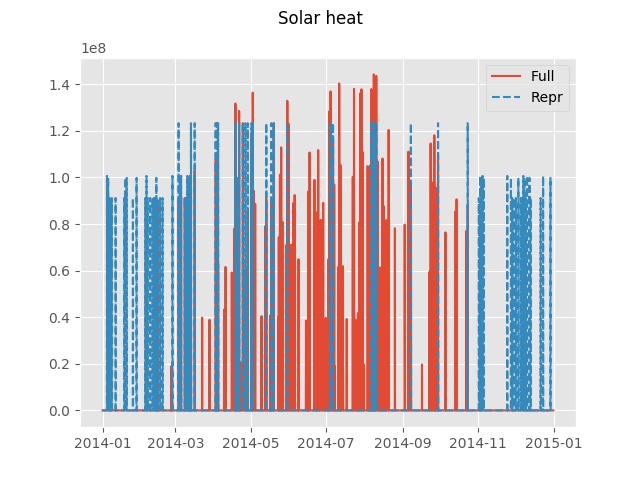

In [16]:
fig, ax = plt.subplots()

full_sol = opt_full.get_result('heat_flow', node='SolarArray', comp='solar')
repr_sol = opt_repr.get_result('heat_flow', node='SolarArray', comp='solar')

fig.suptitle('Solar heat')
ax.plot(full_sol, label='Full')
ax.plot(repr_sol, '--', label='Repr')

ax.legend()

<IPython.core.display.Javascript object>


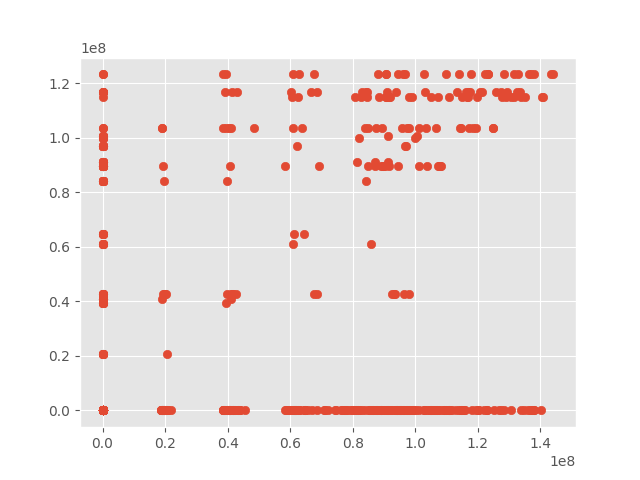

In [17]:
fig, ax = plt.subplots()

ax.scatter(full_sol.values, repr_sol.values)

<IPython.core.display.Javascript object>


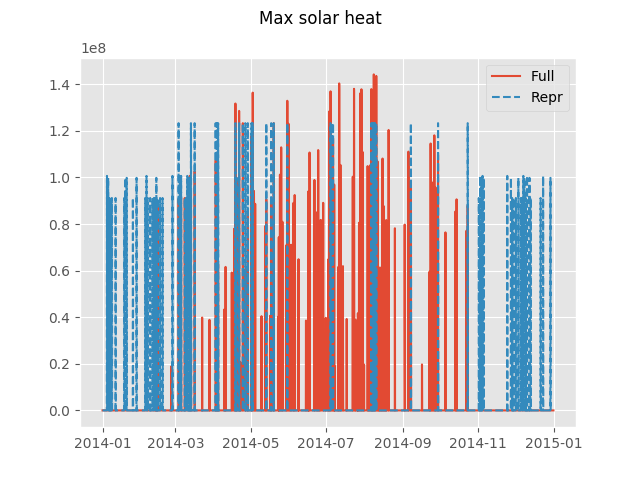

In [18]:
fig, ax = plt.subplots()

full_sol_max = opt_full.get_result('heat_flow_max', node='SolarArray', comp='solar')
repr_sol_max = opt_repr.get_result('heat_flow_max', node='SolarArray', comp='solar')

fig.suptitle('Max solar heat')
ax.plot(full_sol, label='Full')
ax.plot(repr_sol, '--', label='Repr')

ax.legend()

## Compare TSS and modesto data

In [21]:
import numpy as np

def choose_day(df, day):
    return np.array(df[df.index.dayofyear == day+1].values)

def reconstruct(data, repr_d):
    data=data['2014']
    data_restor = []
    for d in xrange(365):
        data_restor.append(choose_day(data, int(repr_d[d])))
    return pd.Series(name=data.name, index=data.index, data=np.concatenate(tuple(data_restor)))


<IPython.core.display.Javascript object>


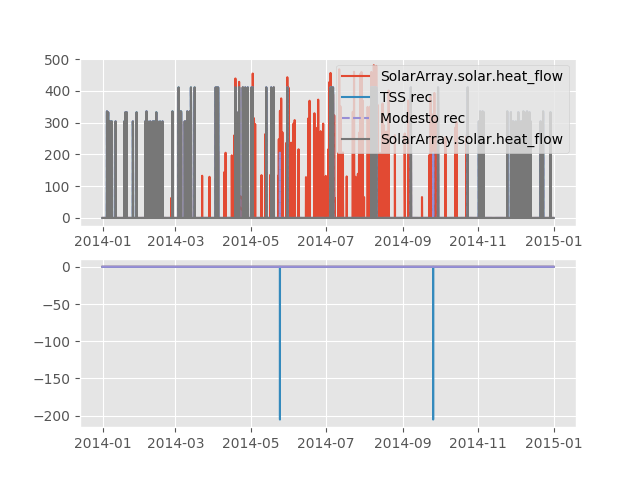

In [22]:
import modesto.utils as utils
tss_data = utils.read_time_data(resource_filename('TimeSliceSelection', 'Data/Renewable'), name='NewSolarThermal.csv')['0_40']
mod_data = utils.read_time_data(resource_filename('modesto', 'Data/RenewableProduction'), name='NewSolarThermal_TSS.csv')['0_40']

tss_data = tss_data.resample('1H').mean()
mod_data = mod_data.resample('1H').mean()



rec_tss_data = reconstruct(tss_data, repr_days[num_days])
rec_mod_data = reconstruct(mod_data, repr_days[num_days])
fig, ax = plt.subplots(2, 1)

#ax[0].plot(tss_data, label= 'TSS')
#ax[0].plot(mod_data, label='Modesto')

ax[0].plot(full_sol/300000, '-')
ax[0].plot(rec_tss_data, '-', label='TSS rec')
ax[0].plot(rec_mod_data, '--', label='Modesto rec')
ax[0].plot(repr_sol/300000, '-')


ax[1].plot(rec_tss_data-rec_mod_data)
ax[1].plot(repr_sol/300000 - rec_mod_data)
ax[1].plot(mod_data - full_sol/300000)

ax[0].legend()

In [23]:
print rec_tss_data.sum()
print rec_mod_data.sum()
print repr_sol.sum()/3e5
print full_sol.sum()/3e5
print mod_data.sum()

108242.07563781738
108242.07563781738
107831.38354493435
108505.04368210468
108505.04368209839


In [24]:
test= pd.DataFrame()
test['Full sol'] = full_sol
test['Repr sol'] = repr_sol
test.head()

,Full sol,Repr sol
2014-01-01 00:00:00,0.0,0.0
2014-01-01 01:00:00,0.0,0.0
2014-01-01 02:00:00,0.0,0.0
2014-01-01 03:00:00,0.0,0.0
2014-01-01 04:00:00,0.0,0.0


In [25]:
print 'Full:',full_sol.sum()
print 'Repr:',repr_sol.sum()

Full: 32551513104.6314
Repr: 32349415063.480305


<IPython.core.display.Javascript object>


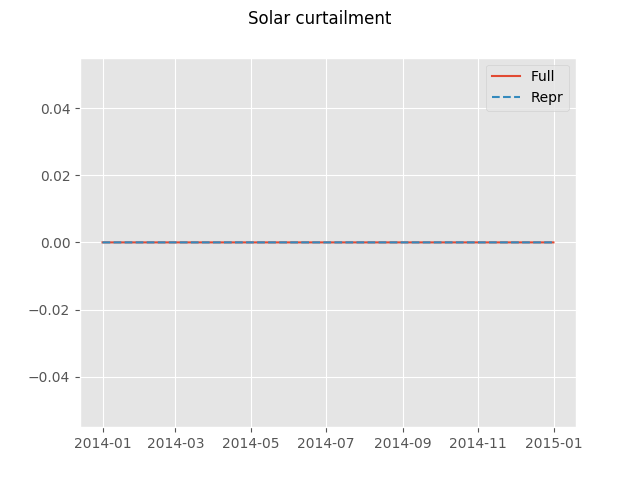

In [26]:
fig, ax = plt.subplots()

full_sol_curt = opt_full.get_result('heat_flow_curt', node='SolarArray', comp='solar')
repr_sol_curt = opt_repr.get_result('heat_flow_curt', node='SolarArray', comp='solar')

fig.suptitle('Solar curtailment')
ax.plot(full_sol_curt, label='Full')
ax.plot(repr_sol_curt, '--', label='Repr')

ax.legend()

In [31]:
full_soc = opt_full.get_result('soc', node='TermienWest', comp='tank')
repr_soc = opt_repr.get_result('soc', node='TermienWest', comp='tank')

<IPython.core.display.Javascript object>


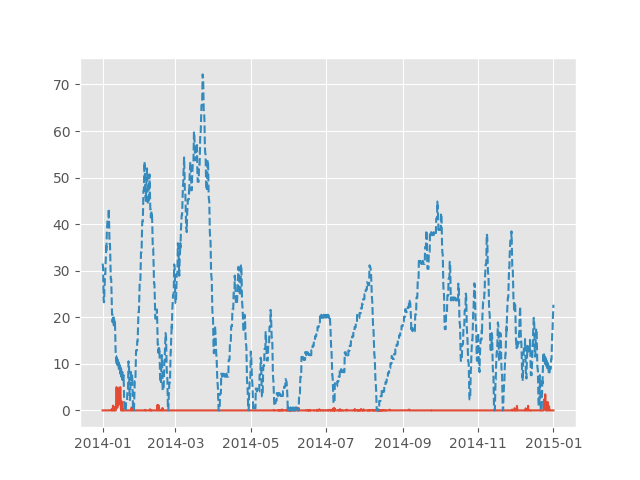

In [33]:
fig, ax = plt.subplots()

ax.plot(full_soc)
ax.plot(repr_soc*100, '--')

In [ ]:
%matplotlib notebook
plt.plot(full_soc/repr_soc)

<IPython.core.display.Javascript object>


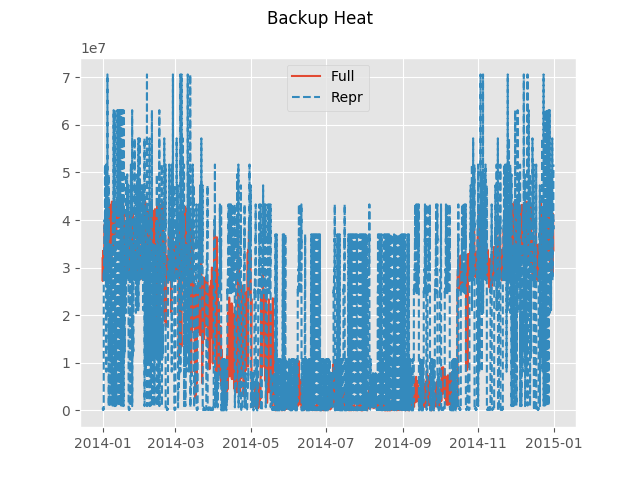

In [30]:
fig, ax = plt.subplots()

full_backup = opt_full.get_result('heat_flow', node='Production', comp='backup')
repr_backup = opt_repr.get_result('heat_flow', node='Production', comp='backup')

fig.suptitle('Backup Heat')
ax.plot(full_backup, label='Full')
ax.plot(repr_backup, '--', label='Repr')

ax.legend()